# Working notebook for the zillow clustering presentation with the following goals:
- #### Using 2017 actual sales data, illuminate the drivers of sales value and find the best model to predict a property's sales price based on its features
- #### Focus examination on logerror - which is based on Zillow's property value estimates (Zestimates).
- #### Clustering should be used to improve feature selection

# I. Initial Imports (additional found in workbook when needed)

In [1]:
#Common DS Libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#Stats Libraries
import scipy.stats as stats

#Modeling
from sklearn.cluster import KMeans
from itertools import combinations
from sklearn.feature_selection import SelectKBest, f_regression, RFE, RFECV
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler

#Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

# II. Load Data

## Examine SQL Database and Acquire

For this analysis, I brought in the entire feature set from the Zillow (aka Codeup) database for all Single Family Residential Properties (code 261), along with the logerror and trmansaction date.

In [2]:
import acquire

In [3]:
# Creates DataFrame from SQL query, or from CSV created when first acquired
df = acquire.get_zillow_data()
df.head()

,parcelid,id,logerror,transactiondate,id.1,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror.1,transactiondate.1
0,14297519,0,0.025595,2017-01-01,1727539,NaN,NaN,NaN,3.5,4.0,...,485713.0,1023282.0,2016.0,537569.0,11013.72,NaN,NaN,6.059063e+13,0.025595,2017-01-01
1,17052889,1,0.055619,2017-01-01,1387261,NaN,NaN,NaN,1.0,2.0,...,88000.0,464000.0,2016.0,376000.0,5672.48,NaN,NaN,6.111001e+13,0.055619,2017-01-01
2,14186244,2,0.005383,2017-01-01,11677,NaN,NaN,NaN,2.0,3.0,...,85289.0,564778.0,2016.0,479489.0,6488.30,NaN,NaN,6.059022e+13,0.005383,2017-01-01
3,12177905,3,-0.103410,2017-01-01,2288172,NaN,NaN,NaN,3.0,4.0,...,108918.0,145143.0,2016.0,36225.0,1777.51,NaN,NaN,6.037300e+13,-0.103410,2017-01-01
4,12095076,6,-0.001011,2017-01-01,781532,1.0,NaN,NaN,3.0,4.0,...,276684.0,773303.0,2016.0,496619.0,9516.26,NaN,NaN,6.037461e+13,-0.001011,2017-01-01


## Initial Data Cleaning - Removing Nulls and Ineffective Rows and Columns

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52442 entries, 0 to 52441
Data columns (total 64 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      52442 non-null  int64  
 1   id                            52442 non-null  int64  
 2   logerror                      52442 non-null  float64
 3   transactiondate               52442 non-null  object 
 4   id.1                          52442 non-null  int64  
 5   airconditioningtypeid         13638 non-null  float64
 6   architecturalstyletypeid      70 non-null     float64
 7   basementsqft                  47 non-null     float64
 8   bathroomcnt                   52442 non-null  float64
 9   bedroomcnt                    52442 non-null  float64
 10  buildingclasstypeid           0 non-null      float64
 11  buildingqualitytypeid         33741 non-null  float64
 12  calculatedbathnbr             52305 non-null  float64
 13  d

There are a lot of null values.  I will eplxiore each feature by nulls and eliminate them with a python script.

In [5]:
import wrangle
import explore

In [6]:
column_nulls = explore.column_null_analyzer(df)
column_nulls[column_nulls['pct_rows_missing']>.25]

,num_rows_missing,pct_rows_missing
,,
finishedsquarefeet15,52442,1.000000
buildingclasstypeid,52442,1.000000
finishedsquarefeet13,52442,1.000000
storytypeid,52395,0.999104
basementsqft,52395,0.999104
yardbuildingsqft26,52379,0.998799
architecturalstyletypeid,52372,0.998665
typeconstructiontypeid,52366,0.998551
fireplaceflag,52361,0.998455


There are 33 rows that have more than 25% of their values missing (they all have more than 35% of rows missing in fact)

There are also a number of duplicate columns to remove (some of these were determined in later cleaning steps and going to take care of them now):

In [7]:
# For many columns examined to see if column data was the same by subtracting them then seeing if any values were not zero
columns_to_remove = [
    'id.1', # different values but redundant with id
    'transactiondate.1', # same as transactiondate
    'logerror.1', # same as logerror
    'propertylandusetypeid', # same for all properties: 261
    'censustractandblock', # same as rawcensustractandblock, except 10**6 higher
    'finishedsquarefeet12', # same as calculatedfinsihedsquarefeet but with 247 less rows
    'regionidcounty', # same as fips - found in distribution analysis
    'roomcnt', # too many zeros - found in distribution analysis
    'assessmentyear', # All 2016
    'regionidzip', # Inaacurate (all zips in Oregon, not SoCal)
    'rawcensustractandblock', # unhelpful - discovered in distribution analysis
    'bathroomcnt', # redundant with calculatedbathnbr
    'fullbathcnt', # redundant with calculatedbathnbr
    'id']

In [8]:
# #Example code to determine column differences
# x='censustractandblock'
# y='rawcensustractandblock'
# df['diff_c'] = df[x]-df[y]
# df[['diff_c',x,y]]

Using a function to remove these null columns (creating a save point first):

In [9]:
df_sp1 = df.copy()
df = wrangle.data_prep(df, cols_to_remove = columns_to_remove)
df.info()

Features removed: 
['id', 'id.1', 'airconditioningtypeid', 'architecturalstyletypeid', 'basementsqft', 'bathroomcnt', 'buildingclasstypeid', 'buildingqualitytypeid', 'decktypeid', 'finishedfloor1squarefeet', 'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6', 'fireplacecnt', 'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa', 'heatingorsystemtypeid', 'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'propertylandusetypeid', 'propertyzoningdesc', 'rawcensustractandblock', 'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt', 'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid', 'unitcnt', 'yardbuildingsqft17', 'yardbuildingsqft26', 'numberofstories', 'fireplaceflag', 'assessmentyear', 'taxdelinquencyflag', 'taxdelinquencyyear', 'censustractandblock', 'logerror.1', 'transactiondate.1']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 50859 entries, 0 to 52441


### Univariate Distribution Analysis

parcelid


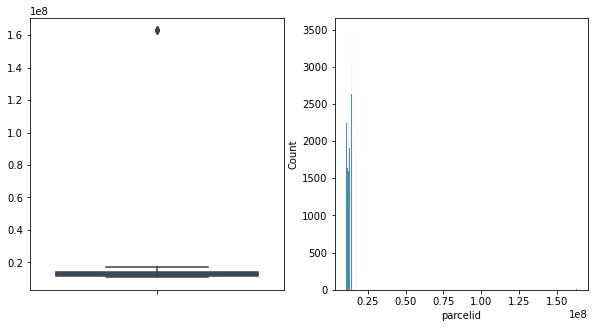

13083743    3
14236060    2
12347492    2
13885693    2
10779619    2
           ..
14334828    1
11060801    1
14491400    1
11187000    1
12826780    1
Name: parcelid, Length: 50745, dtype: int64

-----

logerror


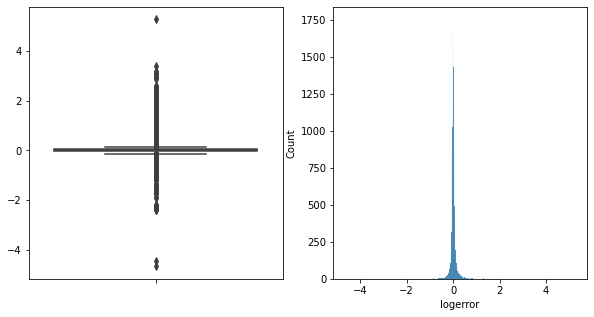

 0.002652    5
 0.000727    5
 0.001878    5
 0.000231    5
 0.000420    4
            ..
-0.001408    1
-0.090209    1
 0.129455    1
 0.030372    1
 0.037129    1
Name: logerror, Length: 50613, dtype: int64

-----

bedroomcnt


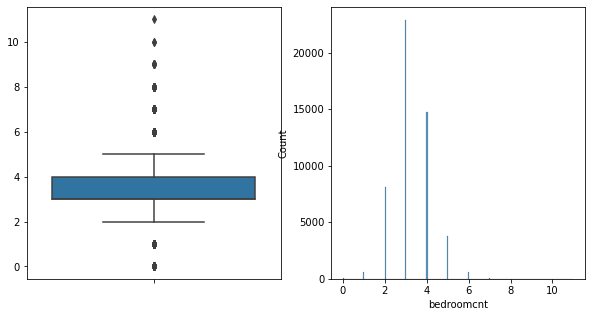

3.0     22890
4.0     14743
2.0      8128
5.0      3770
6.0       605
1.0       561
7.0       100
0.0        28
8.0        23
9.0         8
10.0        2
11.0        1
Name: bedroomcnt, dtype: int64

-----

calculatedbathnbr


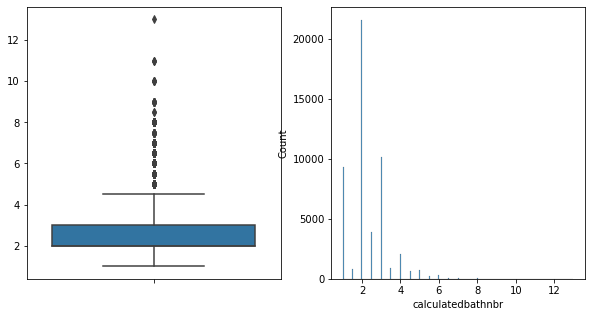

2.0     21573
3.0     10172
1.0      9349
2.5      3867
4.0      2072
3.5       886
1.5       817
5.0       741
4.5       660
6.0       283
5.5       221
7.0        85
8.0        49
6.5        45
7.5        16
9.0        12
10.0        5
11.0        3
8.5         2
13.0        1
Name: calculatedbathnbr, dtype: int64

-----

calculatedfinishedsquarefeet


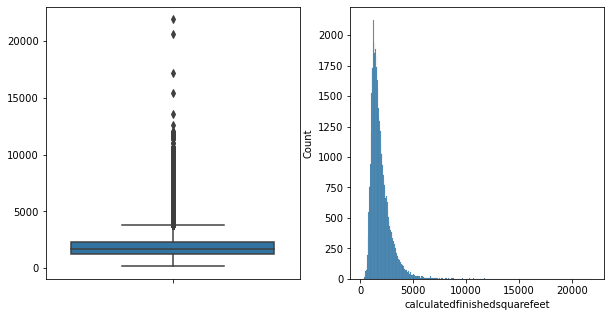

1120.0    128
1200.0    115
1080.0    100
936.0      85
1176.0     83
         ... 
4716.0      1
3509.0      1
4464.0      1
565.0       1
5655.0      1
Name: calculatedfinishedsquarefeet, Length: 4661, dtype: int64

-----

fips


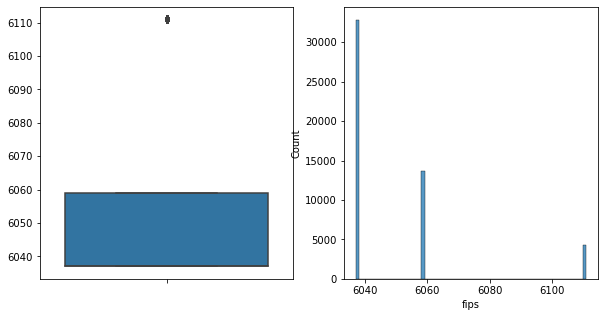

6037.0    32831
6059.0    13689
6111.0     4339
Name: fips, dtype: int64

-----

latitude


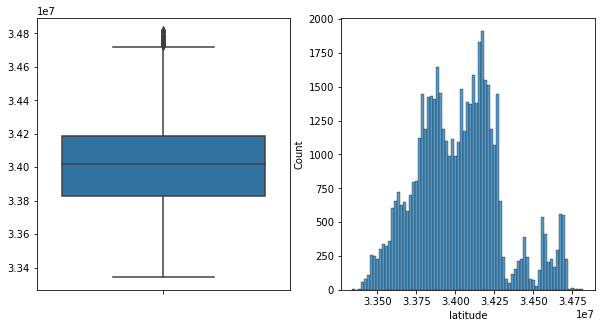

34487900.0    7
34101300.0    7
34041200.0    6
33765800.0    5
33914773.0    4
             ..
33604913.0    1
34188239.0    1
33498277.0    1
33483670.0    1
33937685.0    1
Name: latitude, Length: 49044, dtype: int64

-----

longitude


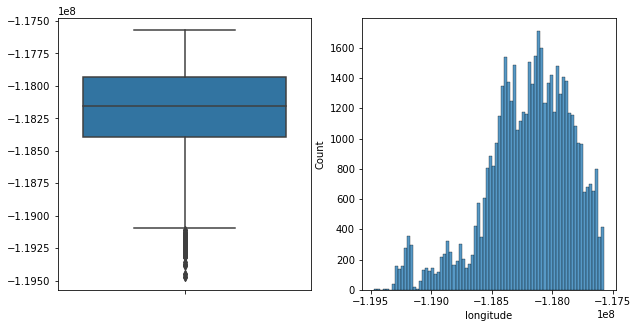

-117835000.0    8
-118172000.0    7
-118327000.0    7
-118251000.0    6
-117853000.0    5
               ..
-118024193.0    1
-117981219.0    1
-117982765.0    1
-118534126.0    1
-117996709.0    1
Name: longitude, Length: 49311, dtype: int64

-----

lotsizesquarefeet


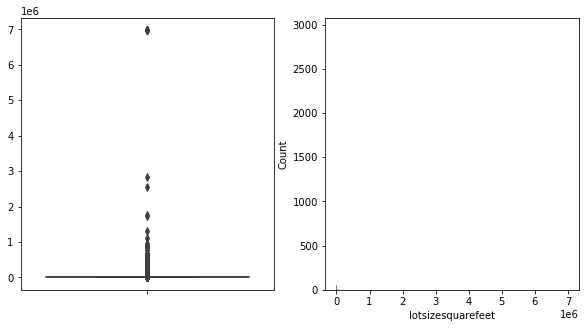

6000.0     869
5000.0     407
7200.0     297
7000.0     282
6500.0     270
          ... 
13569.0      1
1714.0       1
12713.0      1
40594.0      1
47405.0      1
Name: lotsizesquarefeet, Length: 14014, dtype: int64

-----

regionidcity


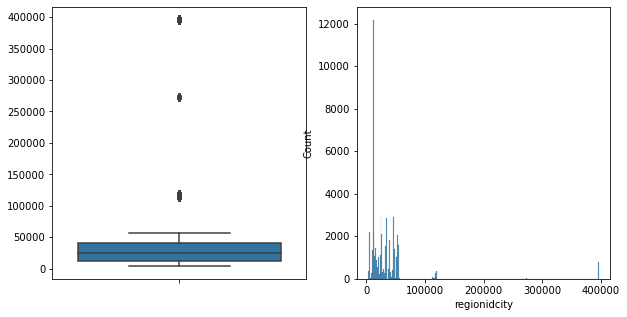

12447.0    11306
5534.0      1766
40227.0     1488
46298.0     1424
16764.0     1079
           ...  
32927.0        3
31134.0        2
36078.0        1
10815.0        1
21395.0        1
Name: regionidcity, Length: 175, dtype: int64

-----

yearbuilt


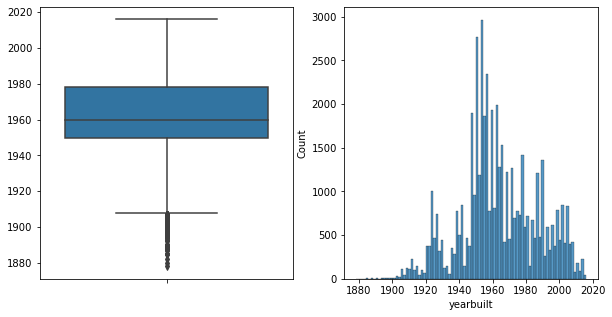

1955.0    1861
1950.0    1593
1954.0    1493
1953.0    1470
1956.0    1351
          ... 
1892.0       1
1878.0       1
1882.0       1
1894.0       1
1880.0       1
Name: yearbuilt, Length: 133, dtype: int64

-----

structuretaxvaluedollarcnt


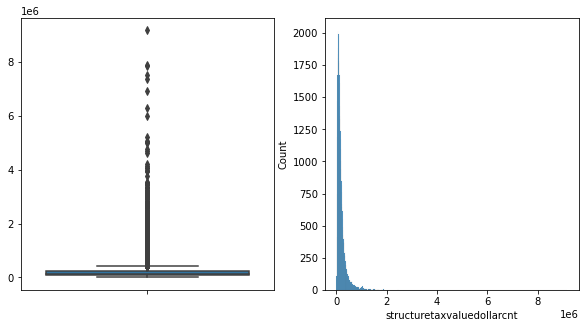

100000.0    48
200000.0    36
90000.0     32
32489.0     27
95000.0     26
            ..
156624.0     1
76353.0      1
68884.0      1
259627.0     1
32797.0      1
Name: structuretaxvaluedollarcnt, Length: 36320, dtype: int64

-----

taxvaluedollarcnt


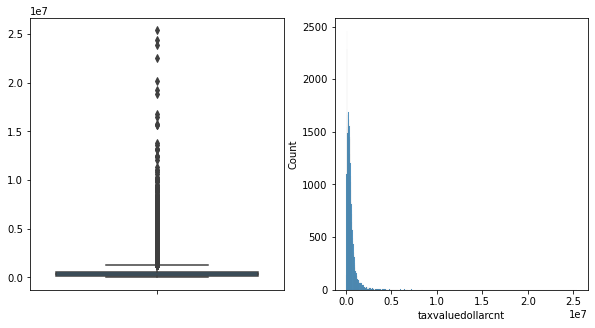

455000.0    32
600000.0    29
500000.0    24
450000.0    24
550000.0    22
            ..
220451.0     1
496121.0     1
315728.0     1
370475.0     1
49546.0      1
Name: taxvaluedollarcnt, Length: 37933, dtype: int64

-----

landtaxvaluedollarcnt


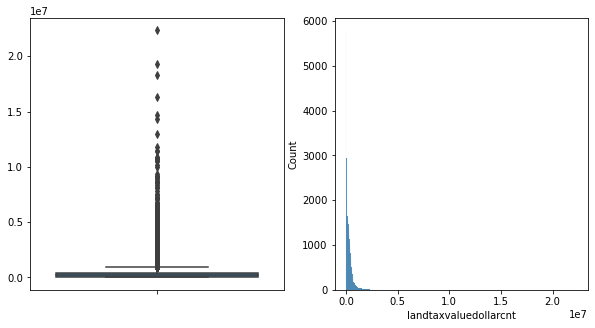

21299.0      94
22755.0      63
30210.0      62
16522.0      54
16749.0      51
             ..
40235.0       1
477331.0      1
1364005.0     1
1091149.0     1
283704.0      1
Name: landtaxvaluedollarcnt, Length: 35924, dtype: int64

-----

taxamount


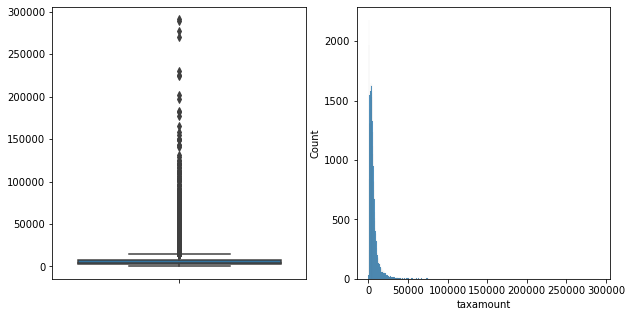

345.72     4
1625.61    3
5387.26    3
3347.58    3
1404.44    3
          ..
3551.82    1
1679.81    1
4430.47    1
2719.44    1
6317.15    1
Name: taxamount, Length: 49331, dtype: int64

-----



In [10]:
for col in df.drop(columns = ['transactiondate','propertycountylandusecode']).columns:
    print(col)
    plt.figure(figsize = (10,5))
    plt.subplot(121)
    sns.boxplot(y=df[col].values)
    plt.subplot(122)
    sns.histplot(x=df[col])
    plt.show()
    print(df[col].value_counts())
    print('\n-----\n')

## Removing Outliers

Based on the distrubtion analysis, and knowledge of the dataset, we're makign the following decisions about outliers:
- id: no outliers
- logerror: target
- latitude: ignore outliers
- longitude: ignore outliers

The following I had to manually check:
- parcelid
- regionidcity
- rawcensustractandblock

In [11]:
df[df['parcelid'] > 20000000]

,parcelid,logerror,transactiondate,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,regionidcity,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount
22841,162960516,0.015797,2017-05-08,3.0,2.5,1449.0,6111.0,34273914.0,-119164501.0,6926.0,1111,34543.0,1986.0,288913.0,481521.0,192608.0,5063.30
23062,162960529,0.007117,2017-05-09,4.0,4.0,2459.0,6111.0,34245590.0,-119169692.0,5400.0,1111,13150.0,2007.0,169000.0,479000.0,310000.0,12285.88
23063,162960529,0.007117,2017-05-26,4.0,4.0,2459.0,6111.0,34245590.0,-119169692.0,5400.0,1111,13150.0,2007.0,169000.0,479000.0,310000.0,12285.88
25734,162960814,-0.006995,2017-05-19,5.0,3.0,2754.0,6111.0,34258186.0,-118731299.0,5742.0,1111,27110.0,2000.0,292666.0,487774.0,195108.0,5602.90
39400,162960596,0.032018,2017-07-18,4.0,2.0,1379.0,6111.0,34219587.0,-119042663.0,7343.0,1111,51239.0,1960.0,224567.0,449134.0,224567.0,4787.16


In [12]:
df[['parcelid','latitude','longitude']].sample(5)

,parcelid,latitude,longitude
9758,14148009,33911149.0,-117915951.0
23639,12710877,33774673.0,-118394573.0
23491,14334010,33759354.0,-117796263.0
38838,11878716,34103786.0,-118177848.0
44756,10843156,34183656.0,-118462896.0


## These properties look fine, so will keep the parcelid outliers but remove it from clustering consideration.  Also, I noticed I need to remember to drop duplicates of parcelid for properties with multiple sales in the year.

In [13]:
# To remove these duplicates, I sort values by date and then keep the last transaction
df = df.sort_values('transactiondate').drop_duplicates(subset='parcelid', keep = 'last')

#### Check on regionidcity and see if they can be used to bin lat and long:

In [14]:
df[df['regionidcity']> 300000]

,parcelid,logerror,transactiondate,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,regionidcity,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount
3,12177905,-0.103410,2017-01-01,4.0,3.0,2376.0,6037.0,34245180.0,-118240722.0,13038.0,0101,396551.0,1970.0,108918.0,145143.0,36225.0,1777.51
60,10925280,-0.004621,2017-01-02,2.0,1.0,1121.0,6037.0,34185108.0,-118354397.0,6055.0,0100,396054.0,1940.0,42238.0,72867.0,30629.0,823.25
228,12805800,-0.017066,2017-01-03,4.0,2.0,1425.0,6037.0,33975042.0,-118072356.0,6175.0,0100,396556.0,1951.0,108067.0,285867.0,177800.0,3669.76
230,11699600,-0.010205,2017-01-03,4.0,4.0,3031.0,6037.0,33998204.0,-118352568.0,10253.0,0100,396550.0,1959.0,391612.0,652684.0,261072.0,8386.02
236,10936058,0.031017,2017-01-03,3.0,2.0,1583.0,6037.0,34174605.0,-118356241.0,10287.0,0100,396054.0,1940.0,129819.0,649101.0,519282.0,7145.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52102,10940022,-0.323309,2017-09-15,2.0,1.0,1238.0,6037.0,34164600.0,-118317591.0,6597.0,0100,396054.0,1938.0,89803.0,224515.0,134712.0,2560.39
51911,11698526,0.013776,2017-09-15,4.0,3.0,2972.0,6037.0,33991365.0,-118347302.0,7598.0,0101,396550.0,1938.0,143100.0,712500.0,569400.0,8988.75
52376,12045845,0.040786,2017-09-19,2.0,2.0,1546.0,6037.0,34216036.0,-118236551.0,4802.0,0100,396551.0,1952.0,157363.0,645698.0,488335.0,4125.12
52415,10957570,-0.047786,2017-09-19,2.0,1.0,1192.0,6037.0,34173515.0,-118339035.0,6047.0,0101,396054.0,1940.0,112559.0,282064.0,169505.0,3110.28


In [15]:
df_ric = df[['latitude','longitude','regionidcity']]
df_rica = df_ric[df_ric['regionidcity'] < 10000].sample(100)
df_rica['regionbin'] = 1
df_ricb = df_ric[(df_ric['regionidcity'] >= 10000) & (df_ric['regionidcity'] < 100000)].sample(100)
df_ricb['regionbin'] = 2
df_ricc = df_ric[(df_ric['regionidcity'] >= 100000) & (df_ric['regionidcity'] < 200000)].sample(100)
df_ricc['regionbin'] = 3
df_ricd = df_ric[df_ric['regionidcity'] >= 200000].sample(100)
df_ricd['regionbin'] = 4
df_ricx = pd.concat([df_rica,df_ricb,df_ricc,df_ricd], axis = 0)
df_ricx

,latitude,longitude,regionidcity,regionbin
38657,34686382.0,-118241977.0,5534.0,1
6023,34688359.0,-118063523.0,5534.0,1
11752,34702046.0,-118100784.0,5534.0,1
26188,34709470.0,-118153817.0,5534.0,1
48730,34652135.0,-118239516.0,5534.0,1
...,...,...,...,...
23713,34197818.0,-118329620.0,396054.0,4
50736,34199336.0,-118292655.0,396054.0,4
18571,34235174.0,-118241765.0,396551.0,4
42650,33949753.0,-118251446.0,396053.0,4


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

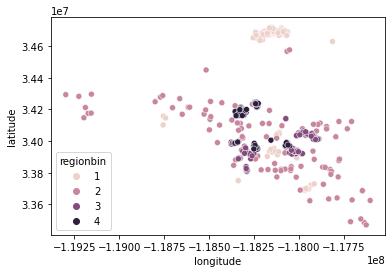

In [16]:
sns.scatterplot(data=df_ricx, x='longitude',y='latitude',hue='regionbin')

Thus, the cities are no geographically located near one another, and since we have this more granular location data we can drop this feature, but for now I will keep it around to possibly use categorically.

#### Census Tract and Block

In [17]:
# REMOVED THIS FEATURE EARLIER AFTER CONDUCTING THIS ANALYSIS

# dfgh = df[['rawcensustractandblock']]/10000000
# scaler = MinMaxScaler()
# scaler.fit(dfgh)
# dfgh = scaler.transform(dfgh)
# dfgh

This would also something of a categorical, if there wasn't something like 30,000 unique values.  The location data is also better captured in the lat/long, so dropping this.

### Now I call my bomb ass function to clean HOUSE.  Deselecting all the rows I don't want to touch for alleged outliers.

In [18]:
df = wrangle.outlier_destroyer(df,2.5,cols_to_remove = ['parcelid','logerror','transactiondate','fips','latitude','longitude','propertycountylandusecode','regionidcity'])

In [19]:
df.info()
df.describe().T

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44572 entries, 0 to 52441
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      44572 non-null  int64  
 1   logerror                      44572 non-null  float64
 2   transactiondate               44572 non-null  object 
 3   bedroomcnt                    44572 non-null  float64
 4   calculatedbathnbr             44572 non-null  float64
 5   calculatedfinishedsquarefeet  44572 non-null  float64
 6   fips                          44572 non-null  float64
 7   latitude                      44572 non-null  float64
 8   longitude                     44572 non-null  float64
 9   lotsizesquarefeet             44572 non-null  float64
 10  propertycountylandusecode     44572 non-null  object 
 11  regionidcity                  44572 non-null  float64
 12  yearbuilt                     44572 non-null  float64
 13  s

,count,mean,std,min,25%,50%,75%,max
parcelid,44572.0,1.298350e+07,2.233186e+06,1.071186e+07,1.155365e+07,1.262477e+07,1.411975e+07,1.629608e+08
logerror,44572.0,1.681131e-02,1.653811e-01,-4.655420e+00,-2.438900e-02,5.986164e-03,3.741104e-02,3.175688e+00
bedroomcnt,44572.0,3.217109e+00,8.569595e-01,1.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,6.000000e+00
calculatedbathnbr,44572.0,2.122139e+00,7.855473e-01,1.000000e+00,2.000000e+00,2.000000e+00,2.500000e+00,5.500000e+00
calculatedfinishedsquarefeet,44572.0,1.718506e+03,6.676859e+02,1.520000e+02,1.234000e+03,1.570000e+03,2.070250e+03,4.781000e+03
fips,44572.0,6.049209e+03,2.099911e+01,6.037000e+03,6.037000e+03,6.037000e+03,6.059000e+03,6.111000e+03
latitude,44572.0,3.401525e+07,2.686402e+05,3.334085e+07,3.382513e+07,3.400074e+07,3.418275e+07,3.471836e+07
longitude,44572.0,-1.181866e+08,3.515427e+05,-1.194754e+08,-1.183805e+08,-1.181407e+08,-1.179330e+08,-1.175723e+08
lotsizesquarefeet,44572.0,6.884377e+03,2.549211e+03,2.360000e+02,5.410750e+03,6.578000e+03,7.911000e+03,1.668800e+04
regionidcity,44572.0,3.421648e+04,5.138155e+04,3.491000e+03,1.244700e+04,2.481200e+04,4.022700e+04,3.965560e+05


#### Last thing - examine data types

#### So, this is an examination of the transactiondate counts, would want to show this and hide axis.  Then come back to this plot later with bivariate where we add in and see if there is any difference in date, and if that is the case should it be binned by impact.  That is the cluster creates a bin score that represents a strong sales period of time. Also, do yourself a favor and clear the axis when you code this for real.

<function matplotlib.pyplot.show(close=None, block=None)>

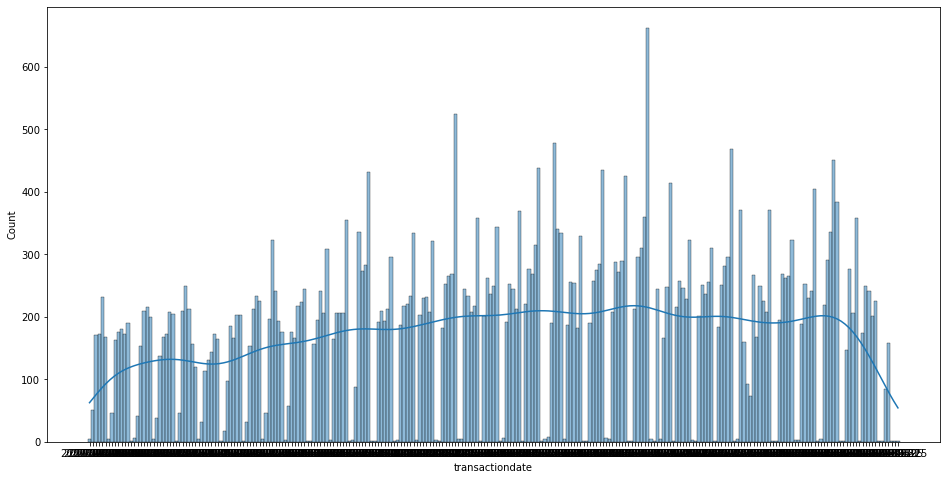

In [20]:
plt.figure(figsize = (16,8))
sns.histplot(df['transactiondate'],kde=True)
plt.show

#### Lastly, I will examine "propertycountylandusecode"

In [21]:
df[['propertycountylandusecode']].value_counts()

propertycountylandusecode
0100                         23906
122                          11530
0101                          4340
1111                          3123
1                              683
1110                           600
0104                           271
0108                            36
010M                            34
010G                            23
0103                            18
0109                             5
0102                             2
0131                             1
dtype: int64

This is really interesting, I discovered that these codes are standardized.  0100 is single residence in LA county; 0101 is single residence with pool; so I'll assume all the 01 are those that are purely single family residences.  The rest might be those also with commercial zoning.

In [22]:
df.groupby(['fips','propertycountylandusecode']).count()

parcelid  logerror  transactiondate  \
fips   propertycountylandusecode                                        
6037.0 0100                          23906     23906            23906   
       0101                           4340      4340             4340   
       0102                              2         2                2   
       0103                             18        18               18   
       0104                            271       271              271   
       0108                             36        36               36   
       0109                              5         5                5   
       010G                             23        23               23   
       010M                             34        34               34   
       0131                              1         1                1   
6059.0 1                               683       683              683   
       122                           11530     11530            11530   
6111.0 1110                            600       600              600   
       1111                           3123      3123             3123   

                                  bedroomcnt  calculatedbathnbr  \
fips   propertycountylandusecode                                  
6037.0 0100                            23906              23906   
       0101                             4340               4340   
       0102                                2                  2   
       0103                               18                 18   
       0104                              271                271   
       0108                               36                 36   
       0109                                5                  5   
       010G                               23                 23   
       010M                               34                 34   
       0131                                1                  1   
6059.0 1                                 683                683   
       122                             11530              11530   
6111.0 1110                              600                600   
       1111                             3123               3123   

                                  calculatedfinishedsquarefeet  latitude  \
fips   propertycountylandusecode                                           
6037.0 0100                                              23906     23906   
       0101                                               4340      4340   
       0102                                                  2         2   
       0103                                                 18        18   
       0104                                                271       271   
       0108                                                 36        36   
       0109                                                  5         5   
       010G                                                 23        23   
       010M                                                 34        34   
       0131                                                  1         1   
6059.0 1                                                   683       683   
       122                                               11530     11530   
6111.0 1110                                                600       600   
       1111                                               3123      3123   

                                  longitude  lotsizesquarefeet  regionidcity  \
fips   propertycountylandusecode                                               
6037.0 0100                           23906              23906         23906   
       0101                            4340               4340          4340   
       0102                               2                  2             2   
       0103                              18                 18            18   
       0104                             271                271           271   
       0108    

I was not able to determine the codes from Ventura or Orange, but I will keep this as a categorical feature.

#### Actual last thing - rename features, convert to integers where possible,  convert fips into string and rename!

In [23]:
df = df.rename(columns={'bathroomcnt':'bathrooms','bedroomcnt':'bedrooms','calculatedfinishedsquarefeet':'sqft','fips':'county','fullbathcnt':'fullbaths','lotsizesquarefeet':'lotsize','regionidcity':'citycode','propertycountylandusecode':'landusecode','structuretaxvaluedollarcnt':'buildingvalue','taxvaluedollarcnt':'propertyvalue','landtaxvaluedollarcnt':'landvalue'})

In [24]:
df = df.astype({'sqft':'int', 'bedrooms':'int','calculatedbathnbr':'int', 'lotsize':'int', 'yearbuilt':'int','buildingvalue':'int','propertyvalue':'int','landvalue':'int','taxamount':'int'})

In [25]:
 df['county'] = np.where(df.county == 6037, 'Los Angeles', np.where(df.county == 6059, 'Orange','Ventura') )

## ALSO:
 - We don't need parcelid or id anyore, so can drop those!
 - citycode needs to be an object \*Note: can do this in the initial retyping after renanming
 
 ### All this should be in the wrangle file

In [26]:
df = df.drop(columns=['parcelid'])

In [27]:
df = df.astype({'citycode':'object'})
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44572 entries, 0 to 52441
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   logerror           44572 non-null  float64
 1   transactiondate    44572 non-null  object 
 2   bedrooms           44572 non-null  int64  
 3   calculatedbathnbr  44572 non-null  int64  
 4   sqft               44572 non-null  int64  
 5   county             44572 non-null  object 
 6   latitude           44572 non-null  float64
 7   longitude          44572 non-null  float64
 8   lotsize            44572 non-null  int64  
 9   landusecode        44572 non-null  object 
 10  citycode           44572 non-null  object 
 11  yearbuilt          44572 non-null  int64  
 12  buildingvalue      44572 non-null  int64  
 13  propertyvalue      44572 non-null  int64  
 14  landvalue          44572 non-null  int64  
 15  taxamount          44572 non-null  int64  
dtypes: float64(3), int64(9

# FIRST CLUSTERING!

run a function that loops through each numerical column and runs it as the k means test against target variable.

In [28]:
features = list(df.columns)
features

['logerror',
 'transactiondate',
 'bedrooms',
 'calculatedbathnbr',
 'sqft',
 'county',
 'latitude',
 'longitude',
 'lotsize',
 'landusecode',
 'citycode',
 'yearbuilt',
 'buildingvalue',
 'propertyvalue',
 'landvalue',
 'taxamount']

In [29]:
features_to_remove = ['transactiondate','county','landusecode','citycode']
features = list(set(features)-set(features_to_remove))
features

['sqft',
 'propertyvalue',
 'buildingvalue',
 'longitude',
 'calculatedbathnbr',
 'yearbuilt',
 'logerror',
 'latitude',
 'taxamount',
 'landvalue',
 'lotsize',
 'bedrooms']

In [30]:
df_to_scale = df[features]
df_to_scale

,sqft,propertyvalue,buildingvalue,longitude,calculatedbathnbr,yearbuilt,logerror,latitude,taxamount,landvalue,lotsize,bedrooms
0,3100,1023282,485713,-117869207.0,3,1998,0.025595,33634931.0,11013,537569,4506,4
1,1465,464000,88000,-119281531.0,1,1967,0.055619,34449266.0,5672,376000,12647,2
2,1243,564778,85289,-117823170.0,2,1962,0.005383,33886168.0,6488,479489,8432,3
3,2376,145143,108918,-118240722.0,3,1970,-0.103410,34245180.0,1777,36225,13038,4
5,738,218552,18890,-118239357.0,1,1922,0.101723,34149214.0,2366,199662,4214,2
...,...,...,...,...,...,...,...,...,...,...,...,...
52310,1116,283826,110241,-117974827.0,2,1955,0.058076,34044604.0,3554,173585,6153,3
52438,1612,67205,50683,-118706327.0,2,1964,0.013209,34300140.0,1107,16522,12105,4
52439,1032,49546,32797,-118038169.0,1,1954,0.037129,34040895.0,876,16749,5074,3
52440,1762,522000,140000,-117996709.0,2,1955,0.007204,33937685.0,6317,382000,6347,3


In [31]:
Y = df_to_scale.logerror
scaler = MinMaxScaler()
scaler.fit(df_to_scale.drop(columns='logerror'))

# Fit the data
df_clustering = pd.DataFrame(scaler.transform(df_to_scale.drop(columns='logerror')),columns=df_to_scale.drop(columns='logerror').columns.values).set_index([df_to_scale.index.values])
df_clustering = pd.concat([df_clustering,Y],axis=1)
df_clustering

,sqft,propertyvalue,buildingvalue,longitude,calculatedbathnbr,yearbuilt,latitude,taxamount,landvalue,lotsize,bedrooms,logerror
0,0.636855,0.615367,0.833339,0.844006,0.50,0.865672,0.213487,0.585246,0.432729,0.259543,0.6,0.025595
1,0.283647,0.277961,0.150774,0.101880,0.00,0.634328,0.804654,0.300149,0.302123,0.754376,0.2,0.055619
2,0.235688,0.338759,0.146121,0.868197,0.25,0.597015,0.395873,0.343707,0.385780,0.498177,0.4,0.005383
3,0.480449,0.085599,0.186674,0.648788,0.50,0.656716,0.656498,0.092239,0.027464,0.778142,0.6,-0.103410
5,0.126593,0.129886,0.032165,0.649505,0.00,0.298507,0.586831,0.123679,0.159579,0.241794,0.2,0.101723
...,...,...,...,...,...,...,...,...,...,...,...,...
52310,0.208252,0.169265,0.188944,0.788506,0.25,0.544776,0.510890,0.187093,0.138500,0.359652,0.4,0.058076
52438,0.315403,0.038581,0.086729,0.404129,0.25,0.611940,0.696396,0.056475,0.011537,0.721432,0.6,0.013209
52439,0.190106,0.027927,0.056033,0.755222,0.00,0.537313,0.508197,0.044144,0.011720,0.294068,0.4,0.037129
52440,0.347807,0.312951,0.240018,0.777008,0.25,0.544776,0.433272,0.334579,0.306974,0.371444,0.4,0.007204


In [32]:
cluster_inputs = list(combinations(features,2))

## Plotted all variables against one another (commented out for file size considerations).  Determined:
- Lat and long unnecessary unless used to create high k geo clusters.
- Discrete variables not very useful.  Pulling.
- Also used all the scatterplots as unofficial EDA (since this was the entire dataset)

In [33]:
# for input in cluster_inputs:
#     cluster = df_clustering[list(input)]
#     for k in range(2,7):
#         kmeans = KMeans(n_clusters = k)
#         kmeans.fit(cluster)
#         cluster['cluster'] = kmeans.predict(cluster)
#         print(f'-----\n\n{k} clusters looking at {input} features:')
#         plt.figure(figsize = (8,8))
#         plt.title(f'x = {input[0]} and y = {input[1]}')
#         sns.scatterplot(data = cluster, x = input[0], y = input[1], hue='cluster')
#         plt.show()
#         cluster = cluster.drop(columns='cluster')